<center><h1> Next-day Stock Price Forecasting using LSTM model with Tensorflow/Keras</h1></center>  

Goal: Predict next-day close price for AAPL stock (daily regression)
Dataset: Daily OHLCV from Yahoo Finance, last 5 years (~1250 rows)
Pipeline: CSV download → preprocessing → train/test split → feature engineering → model → deployment
Serving & scaling: Expose API in Streamlit, handle multiple users
Monitoring: Track MAE/RMSE on latest predictions, detect drift
Tradeoffs & retraining: Decide update frequency (weekly/monthly), adjust features or model if performance drops  

In [2]:
import yfinance as yf
import pandas as pd

import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

2025-10-15 19:42:52.890811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Load and preprocess
df_tfk = pd.read_csv("AAPL_5y_daily.csv", index_col=[0], parse_dates=True)
df_tfk = df_tfk.rename(columns={'Adj Close': 'Adj_Close'})

# Create the Target column
df_tfk['Target'] = df_tfk['Adj_Close'].shift(-1)
df_tfk = df_tfk.dropna()

# Defineing features (X) and target (y)
features = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']
target = 'Target'

X = df_tfk[features]
y = df_tfk[target]


# Splitting data
train_size = int(len(df_tfk) * 0.8)
val_size = int(len(df_tfk) * 0.1)

X_train = X.iloc[:train_size].values
y_train = y.iloc[:train_size].values

X_val = X.iloc[train_size:train_size + val_size].values
y_val = y.iloc[train_size:train_size + val_size].values

X_test = X.iloc[train_size + val_size:].values
y_test = y.iloc[train_size + val_size:].values

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1004, Val: 125, Test: 126


In [6]:
# Scaling

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit only on training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

# Transform validation and test using same scaler
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


### Create Sequences for LSTM   
Each sample = last 60 days → predict next day.

In [9]:
def create_sequences(X, y, time_steps=60):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 60

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

#### Thus the above function reorganize the data resulting in for example for X_train_seq (926, 60, 6) - 926 sequences (986-60), 60 - time step, and 6 - features.¶    


## Build LSTM model¶

In [13]:

model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_steps, len(features))),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,641 (471.25 KB)

 Trainable params: 120,641 (471.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Parameters in neural networks:  
Parameters = weights + biases that the model learns during training.  
Every layer in the network has:  
Weights — the learned multipliers for inputs.  
Biases — the learned offset values added after multiplying inputs by weights.  
Together, these control how the model transforms input into output.  
In total we have 31137 parameters

### ### Train and test the model with validation set

In [17]:

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0312 - val_loss: 0.0081
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0058 - val_loss: 0.0071
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0047 - val_loss: 0.0060
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0036 - val_loss: 0.0059
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0034 - val_loss: 0.0061
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 9/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0031 - val_loss: 0.0052
Epoch 10/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 11/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0028 - val_loss: 0.0051
Epoch 12/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss:

### Evaluation

In [20]:

# Predict on test set
y_pred_scaled = model_lstm.predict(X_test_seq)

# Inverse scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

rmse = sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Test RMSE: 6.949
Test MAE: 5.352


### Visualization

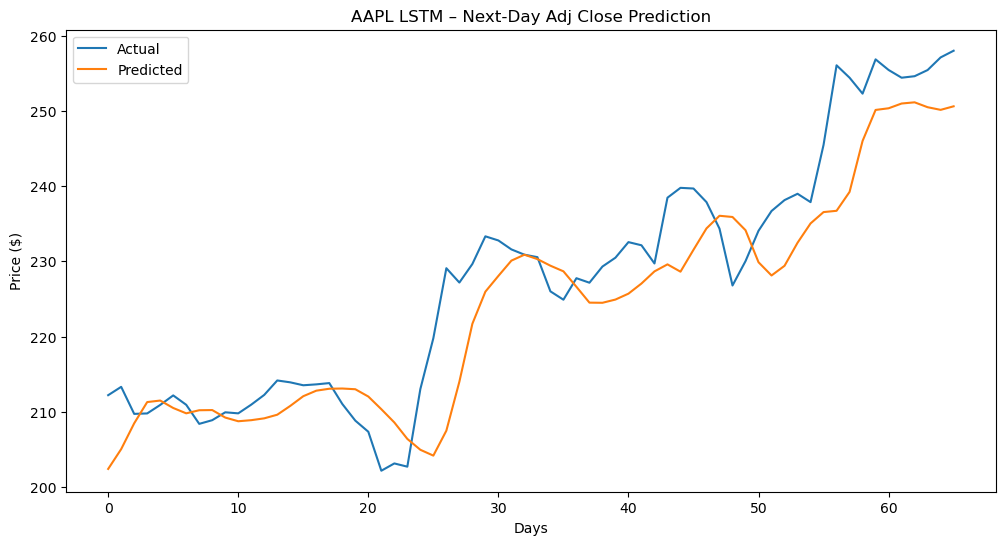

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted next-day Adj Close: $251.38


In [23]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('AAPL LSTM – Next-Day Adj Close Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


# Predicting next-day stock price
last_90_days = X_test_scaled[-time_steps:]
last_90_days = np.expand_dims(last_90_days, axis=0)

next_day_scaled = model_lstm.predict(last_90_days)
next_day_pred = scaler_y.inverse_transform(next_day_scaled)

print(f"Predicted next-day Adj Close: ${next_day_pred[0][0]:.2f}")


### timestep=60:   
Test RMSE: 6.949  
Test MAE: 5.352
